In [1]:
# Name:         Anay Abhijit Joshi
# Date:         November 18, 2024
# Homework 4:   Graph Classification

In [2]:
# Installing PyTorch Geometric dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric
!pip install torch torchvision torchaudio

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [3]:
# Importing the necessary Python modules and libraries again.
import os
import zipfile

# Defining the name of the ZIP file and the extraction directory
zip_filename = "ENZYMES.zip"
extract_path = "enzymes_data"

# Extracting the ZIP file
# Success Case
if zipfile.is_zipfile(zip_filename):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed successfully.")
# Fail Case
else:
    print("Error: The file is not a valid ZIP archive.")

print(" ")

# Defining the paths for the dataset files
enzymes_dir = extract_path
adjacency_file = os.path.join(enzymes_dir, "ENZYMES/ENZYMES_A.txt")
graph_indicator_file = os.path.join(enzymes_dir, "ENZYMES/ENZYMES_graph_indicator.txt")
graph_labels_file = os.path.join(enzymes_dir, "ENZYMES/ENZYMES_graph_labels.txt")
node_attributes_file = os.path.join(enzymes_dir, "ENZYMES/ENZYMES_node_attributes.txt")
node_labels_file = os.path.join(enzymes_dir, "ENZYMES/ENZYMES_node_labels.txt")

# Verifying that the extracted files exist
required_files = [
    adjacency_file,
    graph_indicator_file,
    graph_labels_file,
    node_attributes_file,
    node_labels_file
]

for file in required_files:
    if not os.path.exists(file):
        print(f"Error! Required file missing: {file}")
    else:
        print(f"File found: {file}")

# Loading the data
def load_file(filepath):
    """Reads a file and returns its contents as a list of lines."""
    with open(filepath, 'r') as file:
        data = file.readlines()
    return data

# Loading each file
adjacency_data = load_file(adjacency_file)
graph_indicator_data = load_file(graph_indicator_file)
graph_labels_data = load_file(graph_labels_file)
node_attributes_data = load_file(node_attributes_file)
node_labels_data = load_file(node_labels_file)

# Printing the summary of loaded data
print(" ")
print(f"Adjacency Matrix: {len(adjacency_data)} lines loaded.")
print(f"Graph Indicator: {len(graph_indicator_data)} lines loaded.")
print(f"Graph Labels: {len(graph_labels_data)} lines loaded.")
print(f"Node Attributes: {len(node_attributes_data)} lines loaded.")
print(f"Node Labels: {len(node_labels_data)} lines loaded.")

Extraction completed successfully.
 
File found: enzymes_data/ENZYMES/ENZYMES_A.txt
File found: enzymes_data/ENZYMES/ENZYMES_graph_indicator.txt
File found: enzymes_data/ENZYMES/ENZYMES_graph_labels.txt
File found: enzymes_data/ENZYMES/ENZYMES_node_attributes.txt
File found: enzymes_data/ENZYMES/ENZYMES_node_labels.txt
 
Adjacency Matrix: 74564 lines loaded.
Graph Indicator: 19580 lines loaded.
Graph Labels: 600 lines loaded.
Node Attributes: 19580 lines loaded.
Node Labels: 19580 lines loaded.


In [4]:
# Importing the necessary Python modules and libraries again.
import torch
import datetime
import numpy as np
import pandas as pd
import torch.nn as nn
import sklearn.metrics
import torch.optim as optim
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import BatchNorm1d
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import Data, DataLoader

# Now, again, let's load and preprocess dataset files
def load_file(filepath):
    with open(filepath, 'r') as f:
        return [line.strip() for line in f]

# Load data
adjacency_data = load_file(adjacency_file)
graph_indicator_data = np.array(load_file(graph_indicator_file), dtype=int)
graph_labels_data = np.array(load_file(graph_labels_file), dtype=int)
node_attributes_data = np.array([list(map(float, line.split(','))) for line in load_file(node_attributes_file)])

# Prepare edges
edges = np.array([list(map(int, line.split(','))) for line in adjacency_data])

# Prepare graph data
graphs = {i: {'nodes': [], 'edges': []} for i in range(1, graph_indicator_data.max() + 1)}

# Assign nodes to graphs
for idx, graph_id in enumerate(graph_indicator_data):
    graphs[graph_id]['nodes'].append(idx)

# Assign edges to graphs
for edge in edges:
    src, dest = edge - 1  # Adjust to zero-based indexing
    graph_id = graph_indicator_data[src]
    graphs[graph_id]['edges'].append((src, dest))

# Construct PyTorch Geometric Data objects
graph_data = []
for graph_id, graph in graphs.items():
    nodes = graph['nodes']
    min_node = min(nodes)
    edge_index = torch.tensor(
        [(src - min_node, dest - min_node) for src, dest in graph['edges'] if src in nodes and dest in nodes],
        dtype=torch.long
    ).t().contiguous()
    x = torch.tensor(node_attributes_data[nodes], dtype=torch.float)
    y = torch.tensor([graph_labels_data[graph_id - 1] - 1], dtype=torch.long)  # Adjust label to zero-based indexing
    graph_data.append(Data(x=x, edge_index=edge_index, y=y))

# Normalize features
def normalize_features(graphs):
    for graph in graphs:
        mean = graph.x.mean(dim=0, keepdim=True)
        std = graph.x.std(dim=0, keepdim=True) + 1e-6
        graph.x = (graph.x - mean) / std
# Calling the function for NORMALIZATION
normalize_features(graph_data)

# Apply Principal Component Analysis (PCA) to reduce feature dimensionality
# https://medium.com/analytics-vidhya/dimensionality-reduction-principal-component-analysis-d1402b58feb1
def apply_pca(graphs, n_components=5):
    combined_features = torch.cat([graph.x for graph in graphs], dim=0).numpy()
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(combined_features)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    start = 0
    for graph in graphs:
        num_nodes = graph.x.size(0)
        graph.x = torch.tensor(reduced_features[start:start + num_nodes], dtype=torch.float32)
        start += num_nodes
# Calling the function for applying PCA
apply_pca(graph_data)

# Spliting into training, validation, and testing data sets (70%-15%-15%)
train_data, temp_data = train_test_split(graph_data, test_size=0.3, random_state=42)
# 1/2 of 30% is 15%-15%
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Create DataLoaders now, with a batch size of 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


PCA explained variance ratio: [0.6249682  0.14129734 0.09807628 0.07090252 0.02341201]


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# Defining the GCN Model in a class and its methods, following the Object Oriented Programming (OOP) Principles
# I am using the PyTorch Geometric
# https://pytorch-geometric.readthedocs.io/en/2.5.0/generated/torch_geometric.nn.models.GCN.html

# This class uses Regularization methods, which makes it better for GCN models with more number of layers and/or less number of layers too
class GCN(nn.Module):
    # Constructor
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # First GCN layer (input_dim -> hidden_dim)
        self.convs.append(GCNConv(input_dim, hidden_dim))  # input_dim is now the reduced dimension after PCA
        self.bns.append(BatchNorm1d(hidden_dim))

        # Intermediate GCN layers (hidden_dim -> hidden_dim)
        # Using the iterative loop - "for"
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(BatchNorm1d(hidden_dim))

        # Final GCN layer (hidden_dim -> output_dim)
        # Using the conditional loop here...
        if num_layers == 1:
            self.convs.append(GCNConv(input_dim, output_dim))
        else:
            self.convs.append(GCNConv(hidden_dim, output_dim))

    # Now, let's do the forward pass through the GCN
    def forward(self, data):
        # Extracting the Input Data
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Now, let's apply to the GCN Layers, iterate
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index).relu()
            # Batch Normalization
            x = self.bns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        # Final layer without ReLU
        x = self.convs[-1](x, edge_index)
        # Global pooling to aggregate node features
        return global_mean_pool(x, batch)

In [6]:
# Importing the necessary Python modules and libraries again.
from tqdm import tqdm
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
from datetime import datetime


# Training Loop for Graph Classification, I wanted it to have the bar for better visuality and quick look
def train_with_validation(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    # Iterate again
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0

        # Training Progress Bar, as I mentioned earlier
        with tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", unit="batch") as t:
            for data in t:
                optimizer.zero_grad()
                out = model(data)  # Forward pass
                loss = criterion(out, data.y)  # Use graph-level labels
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                t.set_postfix(Loss=total_loss / len(train_loader))

        # Validation Metrics
        val_f1, val_accuracy = evaluate(model, val_loader)
        print(f"Validation Accuracy: {val_accuracy:.4f},       Validation F1 Score: {val_f1:.4f}")


# Redifne the function with minimal changes in it
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        out = model(data).argmax(dim=1)
        y_true.append(data.y.numpy())  # Graph-level labels
        y_pred.append(out.numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    # Return F1 and Accuracy
    return f1, accuracy


# Again, have the GCN function, modifying a bit, if necessary
class GCN(torch.nn.Module):
    # Constructor
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(GCN, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(input_dim, hidden_dim))
        # Iterate over the "for" loop
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))
        self.out_layer = GCNConv(hidden_dim, output_dim)

    # Now, let's do the forward pass through the GCN
    def forward(self, data):
        # Extracting the Input Data
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Now, let's apply to the GCN Layers, iterate
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
        x = self.out_layer(x, edge_index)
        # Global pooling to aggregate node features
        x = global_mean_pool(x, batch)
        return F.log_softmax(x, dim=1)

In [7]:
# Testing a specific functionality of Python Coding.
# https://www.w3schools.com/python/ref_string_split.asp

def GCN_num_layers(*, model_name):
    # Extract number of layers from model name
    num_layers = int(model_name.split('-')[-1])
    print(f"{num_layers}")

GCN_num_layers(model_name="GCN-Layer-4")
GCN_num_layers(model_name="GCN-Layer-3")
GCN_num_layers(model_name="GCN-Layer-2")
GCN_num_layers(model_name="GCN-Layer-1")

4
3
2
1


In [24]:
# Importing the necessary Python modules and libraries again.
import torch
import os
from datetime import datetime

# Directory to store ".pth" files
# https://medium.com/@yulin_li/what-exactly-is-the-pth-file-9a487044a36b
RESULTS_DIR = "model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# test_model() function, as per the given requirement
def test_model(*, model_name):
    """
    Test a GCN model with a specified number of layers and evaluate its performance.

    -----------
    Function Parameters:
    -----------
    model_name : str
        The name of the model to train and evaluate. Please choose the model name:
        - 'GCN-Layer-1': GCN model with 1 layer.
        - 'GCN-Layer-2': GCN model with 2 layers.
        - 'GCN-Layer-3': GCN model with 3 layers.
        - 'GCN-Layer-4': GCN model with 4 layers.
        -  and so on...

    -----------

    Note:
    -----
    This function uses keyword-only arguments, and the `model_name` parameter is required.
    """
    # Extract number of layers from model name, as tested above in GCN_num_layers()
    num_layers = int(model_name.split('-')[-1])
    # Print the GCN model's name with "x" number of layers
    print(f" ")
    print(f"\nTesting {model_name}...")
    print(f" ")

    # Training Configuration
    input_dim = graph_data[0].x.size(1)
    hidden_dim = 64
    # Number of Classes
    output_dim = len(set(graph_labels_data))
    # Fixed Number of Epochs for consistent testing/evaluation
    num_epochs = 100
    # Fixed Learning Rate for consistent testing/evaluation
    learning_rate = 0.01

    # Defining the Model, Optimizer (Adam), and Criterion/Loss Function(Cross Entropy)
    model = GCN(input_dim, hidden_dim, output_dim, num_layers=num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model with progress bars and validation metrics
    train_with_validation(model, train_loader, val_loader, optimizer, criterion, num_epochs)

    # Evaluate the model on the test set and save probabilities for AUC Curve
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            probs = F.softmax(out, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    # Saving the results to ".pth" file for avoiding the re-running of the code
    results_path = os.path.join(RESULTS_DIR, f"{model_name}_results.pth")
    torch.save({
        "probs": np.array(all_probs),
        "labels": np.array(all_labels),
        "model_name": model_name
    }, results_path)
    print(" ")
    print(f"Results saved to {results_path}\n")

    # Compute Test F1 and Accuracy
    test_f1, test_accuracy = evaluate(model, test_loader)
    print(f"\n")
    print(f"                           Test Accuracy: {test_accuracy:.5f}")
    print(f"                           Test F1 Score: {test_f1:.5f}")
    print(f"\n")
    timestamp = datetime.now()
    print("                           Timestamp:", timestamp)
    print(f"\n")
    # Returns None
    return None

In [10]:
test_model(model_name="GCN-Layer-1")

 

Testing GCN-Layer-1...
 


Epoch 1/100: 100%|██████████| 14/14 [00:00<00:00, 80.13batch/s, Loss=1.81]


Validation Accuracy: 0.2111,       Validation F1 Score: 0.1169


Epoch 2/100: 100%|██████████| 14/14 [00:00<00:00, 69.22batch/s, Loss=1.78]


Validation Accuracy: 0.2889,       Validation F1 Score: 0.2511


Epoch 3/100: 100%|██████████| 14/14 [00:00<00:00, 74.86batch/s, Loss=1.74]


Validation Accuracy: 0.2000,       Validation F1 Score: 0.1332


Epoch 4/100: 100%|██████████| 14/14 [00:00<00:00, 75.98batch/s, Loss=1.75]


Validation Accuracy: 0.2333,       Validation F1 Score: 0.1707


Epoch 5/100: 100%|██████████| 14/14 [00:00<00:00, 68.39batch/s, Loss=1.72]


Validation Accuracy: 0.3333,       Validation F1 Score: 0.3157


Epoch 6/100: 100%|██████████| 14/14 [00:00<00:00, 59.77batch/s, Loss=1.68]


Validation Accuracy: 0.2889,       Validation F1 Score: 0.2114


Epoch 7/100: 100%|██████████| 14/14 [00:00<00:00, 59.64batch/s, Loss=1.67]


Validation Accuracy: 0.2667,       Validation F1 Score: 0.2265


Epoch 8/100: 100%|██████████| 14/14 [00:00<00:00, 68.80batch/s, Loss=1.67]


Validation Accuracy: 0.2667,       Validation F1 Score: 0.2316


Epoch 9/100: 100%|██████████| 14/14 [00:00<00:00, 69.60batch/s, Loss=1.64]


Validation Accuracy: 0.3222,       Validation F1 Score: 0.3234


Epoch 10/100: 100%|██████████| 14/14 [00:00<00:00, 80.65batch/s, Loss=1.62]


Validation Accuracy: 0.2889,       Validation F1 Score: 0.2740


Epoch 11/100: 100%|██████████| 14/14 [00:00<00:00, 73.48batch/s, Loss=1.59]


Validation Accuracy: 0.3111,       Validation F1 Score: 0.2988


Epoch 12/100: 100%|██████████| 14/14 [00:00<00:00, 71.78batch/s, Loss=1.59]


Validation Accuracy: 0.3222,       Validation F1 Score: 0.3122


Epoch 13/100: 100%|██████████| 14/14 [00:00<00:00, 67.69batch/s, Loss=1.61]


Validation Accuracy: 0.3444,       Validation F1 Score: 0.3334


Epoch 14/100: 100%|██████████| 14/14 [00:00<00:00, 60.16batch/s, Loss=1.55]


Validation Accuracy: 0.3111,       Validation F1 Score: 0.2896


Epoch 15/100: 100%|██████████| 14/14 [00:00<00:00, 57.48batch/s, Loss=1.54]


Validation Accuracy: 0.3222,       Validation F1 Score: 0.3068


Epoch 16/100: 100%|██████████| 14/14 [00:00<00:00, 61.35batch/s, Loss=1.57]


Validation Accuracy: 0.3444,       Validation F1 Score: 0.3632


Epoch 17/100: 100%|██████████| 14/14 [00:00<00:00, 74.59batch/s, Loss=1.61]


Validation Accuracy: 0.3111,       Validation F1 Score: 0.2891


Epoch 18/100: 100%|██████████| 14/14 [00:00<00:00, 76.67batch/s, Loss=1.56]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3617


Epoch 19/100: 100%|██████████| 14/14 [00:00<00:00, 72.31batch/s, Loss=1.52]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3866


Epoch 20/100: 100%|██████████| 14/14 [00:00<00:00, 71.97batch/s, Loss=1.55]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3671


Epoch 21/100: 100%|██████████| 14/14 [00:00<00:00, 64.03batch/s, Loss=1.55]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3898


Epoch 22/100: 100%|██████████| 14/14 [00:00<00:00, 51.23batch/s, Loss=1.57]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3710


Epoch 23/100: 100%|██████████| 14/14 [00:00<00:00, 42.11batch/s, Loss=1.53]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3434


Epoch 24/100: 100%|██████████| 14/14 [00:00<00:00, 54.97batch/s, Loss=1.51]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3713


Epoch 25/100: 100%|██████████| 14/14 [00:00<00:00, 59.12batch/s, Loss=1.5]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.3793


Epoch 26/100: 100%|██████████| 14/14 [00:00<00:00, 58.60batch/s, Loss=1.47]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3877


Epoch 27/100: 100%|██████████| 14/14 [00:00<00:00, 57.57batch/s, Loss=1.51]


Validation Accuracy: 0.3444,       Validation F1 Score: 0.3318


Epoch 28/100: 100%|██████████| 14/14 [00:00<00:00, 49.94batch/s, Loss=1.5]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3686


Epoch 29/100: 100%|██████████| 14/14 [00:00<00:00, 51.57batch/s, Loss=1.52]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.4029


Epoch 30/100: 100%|██████████| 14/14 [00:00<00:00, 48.67batch/s, Loss=1.48]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3788


Epoch 31/100: 100%|██████████| 14/14 [00:00<00:00, 55.56batch/s, Loss=1.45]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4341


Epoch 32/100: 100%|██████████| 14/14 [00:00<00:00, 60.93batch/s, Loss=1.48]


Validation Accuracy: 0.3444,       Validation F1 Score: 0.3218


Epoch 33/100: 100%|██████████| 14/14 [00:00<00:00, 59.40batch/s, Loss=1.47]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3669


Epoch 34/100: 100%|██████████| 14/14 [00:00<00:00, 50.61batch/s, Loss=1.49]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3697


Epoch 35/100: 100%|██████████| 14/14 [00:00<00:00, 47.32batch/s, Loss=1.5]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3752


Epoch 36/100: 100%|██████████| 14/14 [00:00<00:00, 46.86batch/s, Loss=1.49]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4211


Epoch 37/100: 100%|██████████| 14/14 [00:00<00:00, 51.84batch/s, Loss=1.43]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.4016


Epoch 38/100: 100%|██████████| 14/14 [00:00<00:00, 76.87batch/s, Loss=1.48]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3431


Epoch 39/100: 100%|██████████| 14/14 [00:00<00:00, 70.11batch/s, Loss=1.46]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.4118


Epoch 40/100: 100%|██████████| 14/14 [00:00<00:00, 76.24batch/s, Loss=1.51]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3760


Epoch 41/100: 100%|██████████| 14/14 [00:00<00:00, 66.34batch/s, Loss=1.46]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3904


Epoch 42/100: 100%|██████████| 14/14 [00:00<00:00, 60.73batch/s, Loss=1.44]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3973


Epoch 43/100: 100%|██████████| 14/14 [00:00<00:00, 59.97batch/s, Loss=1.49]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3349


Epoch 44/100: 100%|██████████| 14/14 [00:00<00:00, 66.15batch/s, Loss=1.42]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3666


Epoch 45/100: 100%|██████████| 14/14 [00:00<00:00, 62.80batch/s, Loss=1.42]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4364


Epoch 46/100: 100%|██████████| 14/14 [00:00<00:00, 79.35batch/s, Loss=1.45]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3463


Epoch 47/100: 100%|██████████| 14/14 [00:00<00:00, 71.68batch/s, Loss=1.44]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3837


Epoch 48/100: 100%|██████████| 14/14 [00:00<00:00, 77.37batch/s, Loss=1.43]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4347


Epoch 49/100: 100%|██████████| 14/14 [00:00<00:00, 74.05batch/s, Loss=1.44]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3473


Epoch 50/100: 100%|██████████| 14/14 [00:00<00:00, 63.97batch/s, Loss=1.47]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3833


Epoch 51/100: 100%|██████████| 14/14 [00:00<00:00, 60.69batch/s, Loss=1.48]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3481


Epoch 52/100: 100%|██████████| 14/14 [00:00<00:00, 61.29batch/s, Loss=1.42]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4219


Epoch 53/100: 100%|██████████| 14/14 [00:00<00:00, 64.75batch/s, Loss=1.41]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3404


Epoch 54/100: 100%|██████████| 14/14 [00:00<00:00, 70.84batch/s, Loss=1.43]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4280


Epoch 55/100: 100%|██████████| 14/14 [00:00<00:00, 75.08batch/s, Loss=1.44]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3933


Epoch 56/100: 100%|██████████| 14/14 [00:00<00:00, 77.80batch/s, Loss=1.42]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.4062


Epoch 57/100: 100%|██████████| 14/14 [00:00<00:00, 75.56batch/s, Loss=1.4]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3577


Epoch 58/100: 100%|██████████| 14/14 [00:00<00:00, 63.85batch/s, Loss=1.41]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4172


Epoch 59/100: 100%|██████████| 14/14 [00:00<00:00, 61.83batch/s, Loss=1.46]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3858


Epoch 60/100: 100%|██████████| 14/14 [00:00<00:00, 60.52batch/s, Loss=1.4]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.4003


Epoch 61/100: 100%|██████████| 14/14 [00:00<00:00, 62.91batch/s, Loss=1.37]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3496


Epoch 62/100: 100%|██████████| 14/14 [00:00<00:00, 76.92batch/s, Loss=1.43]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3674


Epoch 63/100: 100%|██████████| 14/14 [00:00<00:00, 75.48batch/s, Loss=1.5]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.4478


Epoch 64/100: 100%|██████████| 14/14 [00:00<00:00, 73.14batch/s, Loss=1.47]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3567


Epoch 65/100: 100%|██████████| 14/14 [00:00<00:00, 72.17batch/s, Loss=1.42]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3946


Epoch 66/100: 100%|██████████| 14/14 [00:00<00:00, 61.71batch/s, Loss=1.39]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.4128


Epoch 67/100: 100%|██████████| 14/14 [00:00<00:00, 55.58batch/s, Loss=1.39]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3869


Epoch 68/100: 100%|██████████| 14/14 [00:00<00:00, 63.99batch/s, Loss=1.37]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3603


Epoch 69/100: 100%|██████████| 14/14 [00:00<00:00, 63.67batch/s, Loss=1.39]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3788


Epoch 70/100: 100%|██████████| 14/14 [00:00<00:00, 66.31batch/s, Loss=1.38]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4207


Epoch 71/100: 100%|██████████| 14/14 [00:00<00:00, 68.83batch/s, Loss=1.4]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3948


Epoch 72/100: 100%|██████████| 14/14 [00:00<00:00, 70.90batch/s, Loss=1.39]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3805


Epoch 73/100: 100%|██████████| 14/14 [00:00<00:00, 78.71batch/s, Loss=1.43]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4209


Epoch 74/100: 100%|██████████| 14/14 [00:00<00:00, 60.92batch/s, Loss=1.38]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4466


Epoch 75/100: 100%|██████████| 14/14 [00:00<00:00, 62.42batch/s, Loss=1.38]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3857


Epoch 76/100: 100%|██████████| 14/14 [00:00<00:00, 60.83batch/s, Loss=1.39]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3791


Epoch 77/100: 100%|██████████| 14/14 [00:00<00:00, 60.28batch/s, Loss=1.39]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3509


Epoch 78/100: 100%|██████████| 14/14 [00:00<00:00, 67.01batch/s, Loss=1.36]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3776


Epoch 79/100: 100%|██████████| 14/14 [00:00<00:00, 52.00batch/s, Loss=1.35]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3840


Epoch 80/100: 100%|██████████| 14/14 [00:00<00:00, 56.63batch/s, Loss=1.34]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3824


Epoch 81/100: 100%|██████████| 14/14 [00:00<00:00, 55.14batch/s, Loss=1.34]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3850


Epoch 82/100: 100%|██████████| 14/14 [00:00<00:00, 46.35batch/s, Loss=1.39]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3845


Epoch 83/100: 100%|██████████| 14/14 [00:00<00:00, 48.62batch/s, Loss=1.35]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3944


Epoch 84/100: 100%|██████████| 14/14 [00:00<00:00, 54.00batch/s, Loss=1.42]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3820


Epoch 85/100: 100%|██████████| 14/14 [00:00<00:00, 50.08batch/s, Loss=1.34]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3475


Epoch 86/100: 100%|██████████| 14/14 [00:00<00:00, 53.47batch/s, Loss=1.43]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4204


Epoch 87/100: 100%|██████████| 14/14 [00:00<00:00, 52.46batch/s, Loss=1.41]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3517


Epoch 88/100: 100%|██████████| 14/14 [00:00<00:00, 49.90batch/s, Loss=1.37]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3914


Epoch 89/100: 100%|██████████| 14/14 [00:00<00:00, 54.91batch/s, Loss=1.38]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3390


Epoch 90/100: 100%|██████████| 14/14 [00:00<00:00, 56.07batch/s, Loss=1.31]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3779


Epoch 91/100: 100%|██████████| 14/14 [00:00<00:00, 53.03batch/s, Loss=1.31]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3637


Epoch 92/100: 100%|██████████| 14/14 [00:00<00:00, 63.66batch/s, Loss=1.36]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3625


Epoch 93/100: 100%|██████████| 14/14 [00:00<00:00, 56.85batch/s, Loss=1.36]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3530


Epoch 94/100: 100%|██████████| 14/14 [00:00<00:00, 52.09batch/s, Loss=1.33]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4085


Epoch 95/100: 100%|██████████| 14/14 [00:00<00:00, 51.60batch/s, Loss=1.29]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3672


Epoch 96/100: 100%|██████████| 14/14 [00:00<00:00, 60.62batch/s, Loss=1.34]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3747


Epoch 97/100: 100%|██████████| 14/14 [00:00<00:00, 69.16batch/s, Loss=1.35]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3991


Epoch 98/100: 100%|██████████| 14/14 [00:00<00:00, 66.59batch/s, Loss=1.36]


Validation Accuracy: 0.3444,       Validation F1 Score: 0.3273


Epoch 99/100: 100%|██████████| 14/14 [00:00<00:00, 76.41batch/s, Loss=1.39]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3826


Epoch 100/100: 100%|██████████| 14/14 [00:00<00:00, 72.58batch/s, Loss=1.32]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3753
 
Results saved to model_results/GCN-Layer-1_results.pth



                           Test Accuracy: 0.54056
                           Test F1 Score: 0.50496


                           Timestamp: 2024-11-21 10:02:10.647836




In [12]:
test_model(model_name="GCN-Layer-2")

 

Testing GCN-Layer-2...
 


Epoch 1/100: 100%|██████████| 14/14 [00:00<00:00, 42.59batch/s, Loss=1.81]


Validation Accuracy: 0.1889,       Validation F1 Score: 0.0796


Epoch 2/100: 100%|██████████| 14/14 [00:00<00:00, 46.85batch/s, Loss=1.77]


Validation Accuracy: 0.1667,       Validation F1 Score: 0.0732


Epoch 3/100: 100%|██████████| 14/14 [00:00<00:00, 49.45batch/s, Loss=1.73]


Validation Accuracy: 0.2111,       Validation F1 Score: 0.1537


Epoch 4/100: 100%|██████████| 14/14 [00:00<00:00, 48.59batch/s, Loss=1.73]


Validation Accuracy: 0.2556,       Validation F1 Score: 0.1932


Epoch 5/100: 100%|██████████| 14/14 [00:00<00:00, 48.04batch/s, Loss=1.67]


Validation Accuracy: 0.2889,       Validation F1 Score: 0.2707


Epoch 6/100: 100%|██████████| 14/14 [00:00<00:00, 59.17batch/s, Loss=1.62]


Validation Accuracy: 0.2889,       Validation F1 Score: 0.2390


Epoch 7/100: 100%|██████████| 14/14 [00:00<00:00, 50.19batch/s, Loss=1.58]


Validation Accuracy: 0.2667,       Validation F1 Score: 0.2381


Epoch 8/100: 100%|██████████| 14/14 [00:00<00:00, 59.12batch/s, Loss=1.56]


Validation Accuracy: 0.3111,       Validation F1 Score: 0.2726


Epoch 9/100: 100%|██████████| 14/14 [00:00<00:00, 60.11batch/s, Loss=1.54]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3895


Epoch 10/100: 100%|██████████| 14/14 [00:00<00:00, 57.30batch/s, Loss=1.5]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3204


Epoch 11/100: 100%|██████████| 14/14 [00:00<00:00, 46.89batch/s, Loss=1.47]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3671


Epoch 12/100: 100%|██████████| 14/14 [00:00<00:00, 52.11batch/s, Loss=1.46]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3723


Epoch 13/100: 100%|██████████| 14/14 [00:00<00:00, 59.92batch/s, Loss=1.43]


Validation Accuracy: 0.3222,       Validation F1 Score: 0.2935


Epoch 14/100: 100%|██████████| 14/14 [00:00<00:00, 51.51batch/s, Loss=1.4]


Validation Accuracy: 0.3111,       Validation F1 Score: 0.2787


Epoch 15/100: 100%|██████████| 14/14 [00:00<00:00, 55.94batch/s, Loss=1.34]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3722


Epoch 16/100: 100%|██████████| 14/14 [00:00<00:00, 61.44batch/s, Loss=1.35]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3452


Epoch 17/100: 100%|██████████| 14/14 [00:00<00:00, 57.57batch/s, Loss=1.37]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3845


Epoch 18/100: 100%|██████████| 14/14 [00:00<00:00, 49.95batch/s, Loss=1.34]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3339


Epoch 19/100: 100%|██████████| 14/14 [00:00<00:00, 62.13batch/s, Loss=1.32]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3738


Epoch 20/100: 100%|██████████| 14/14 [00:00<00:00, 63.37batch/s, Loss=1.33]


Validation Accuracy: 0.3333,       Validation F1 Score: 0.2969


Epoch 21/100: 100%|██████████| 14/14 [00:00<00:00, 51.40batch/s, Loss=1.26]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.3689


Epoch 22/100: 100%|██████████| 14/14 [00:00<00:00, 54.79batch/s, Loss=1.3]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3610


Epoch 23/100: 100%|██████████| 14/14 [00:00<00:00, 61.83batch/s, Loss=1.28]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.3958


Epoch 24/100: 100%|██████████| 14/14 [00:00<00:00, 58.07batch/s, Loss=1.28]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3305


Epoch 25/100: 100%|██████████| 14/14 [00:00<00:00, 47.57batch/s, Loss=1.18]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.3885


Epoch 26/100: 100%|██████████| 14/14 [00:00<00:00, 59.24batch/s, Loss=1.21]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.3933


Epoch 27/100: 100%|██████████| 14/14 [00:00<00:00, 57.94batch/s, Loss=1.11]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4385


Epoch 28/100: 100%|██████████| 14/14 [00:00<00:00, 47.95batch/s, Loss=1.13]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3368


Epoch 29/100: 100%|██████████| 14/14 [00:00<00:00, 57.73batch/s, Loss=1.17]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3473


Epoch 30/100: 100%|██████████| 14/14 [00:00<00:00, 62.93batch/s, Loss=1.12]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4362


Epoch 31/100: 100%|██████████| 14/14 [00:00<00:00, 52.93batch/s, Loss=1.14]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4597


Epoch 32/100: 100%|██████████| 14/14 [00:00<00:00, 51.68batch/s, Loss=1.12]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3685


Epoch 33/100: 100%|██████████| 14/14 [00:00<00:00, 62.32batch/s, Loss=1.09]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.4060


Epoch 34/100: 100%|██████████| 14/14 [00:00<00:00, 57.71batch/s, Loss=1.15]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3558


Epoch 35/100: 100%|██████████| 14/14 [00:00<00:00, 44.93batch/s, Loss=1.06]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4099


Epoch 36/100: 100%|██████████| 14/14 [00:00<00:00, 61.43batch/s, Loss=1.02]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.3961


Epoch 37/100: 100%|██████████| 14/14 [00:00<00:00, 58.41batch/s, Loss=1.08]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3682


Epoch 38/100: 100%|██████████| 14/14 [00:00<00:00, 43.07batch/s, Loss=0.997]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4065


Epoch 39/100: 100%|██████████| 14/14 [00:00<00:00, 41.94batch/s, Loss=0.97]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.3922


Epoch 40/100: 100%|██████████| 14/14 [00:00<00:00, 43.37batch/s, Loss=0.96]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4270


Epoch 41/100: 100%|██████████| 14/14 [00:00<00:00, 44.68batch/s, Loss=0.937]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4128


Epoch 42/100: 100%|██████████| 14/14 [00:00<00:00, 50.41batch/s, Loss=1.03]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4582


Epoch 43/100: 100%|██████████| 14/14 [00:00<00:00, 47.08batch/s, Loss=0.899]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4379


Epoch 44/100: 100%|██████████| 14/14 [00:00<00:00, 38.06batch/s, Loss=0.921]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.3851


Epoch 45/100: 100%|██████████| 14/14 [00:00<00:00, 43.79batch/s, Loss=0.951]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.4411


Epoch 46/100: 100%|██████████| 14/14 [00:00<00:00, 40.53batch/s, Loss=0.918]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4338


Epoch 47/100: 100%|██████████| 14/14 [00:00<00:00, 45.88batch/s, Loss=0.874]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4175


Epoch 48/100: 100%|██████████| 14/14 [00:00<00:00, 48.57batch/s, Loss=0.933]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4761


Epoch 49/100: 100%|██████████| 14/14 [00:00<00:00, 43.44batch/s, Loss=0.92]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4154


Epoch 50/100: 100%|██████████| 14/14 [00:00<00:00, 43.59batch/s, Loss=0.916]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4729


Epoch 51/100: 100%|██████████| 14/14 [00:00<00:00, 42.55batch/s, Loss=0.877]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.3918


Epoch 52/100: 100%|██████████| 14/14 [00:00<00:00, 50.92batch/s, Loss=0.794]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.4179


Epoch 53/100: 100%|██████████| 14/14 [00:00<00:00, 58.34batch/s, Loss=0.724]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4205


Epoch 54/100: 100%|██████████| 14/14 [00:00<00:00, 52.84batch/s, Loss=0.75]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4488


Epoch 55/100: 100%|██████████| 14/14 [00:00<00:00, 48.02batch/s, Loss=0.752]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4564


Epoch 56/100: 100%|██████████| 14/14 [00:00<00:00, 58.85batch/s, Loss=0.733]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.4329


Epoch 57/100: 100%|██████████| 14/14 [00:00<00:00, 56.47batch/s, Loss=0.692]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.4902


Epoch 58/100: 100%|██████████| 14/14 [00:00<00:00, 52.35batch/s, Loss=0.659]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4593


Epoch 59/100: 100%|██████████| 14/14 [00:00<00:00, 54.58batch/s, Loss=0.689]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4718


Epoch 60/100: 100%|██████████| 14/14 [00:00<00:00, 61.31batch/s, Loss=0.724]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4600


Epoch 61/100: 100%|██████████| 14/14 [00:00<00:00, 50.99batch/s, Loss=0.642]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4096


Epoch 62/100: 100%|██████████| 14/14 [00:00<00:00, 49.48batch/s, Loss=0.625]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4696


Epoch 63/100: 100%|██████████| 14/14 [00:00<00:00, 58.42batch/s, Loss=0.736]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.3901


Epoch 64/100: 100%|██████████| 14/14 [00:00<00:00, 53.31batch/s, Loss=0.65]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.3742


Epoch 65/100: 100%|██████████| 14/14 [00:00<00:00, 50.57batch/s, Loss=0.631]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4663


Epoch 66/100: 100%|██████████| 14/14 [00:00<00:00, 57.76batch/s, Loss=0.642]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4038


Epoch 67/100: 100%|██████████| 14/14 [00:00<00:00, 56.04batch/s, Loss=0.707]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5061


Epoch 68/100: 100%|██████████| 14/14 [00:00<00:00, 45.13batch/s, Loss=0.624]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4644


Epoch 69/100: 100%|██████████| 14/14 [00:00<00:00, 55.66batch/s, Loss=0.648]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4616


Epoch 70/100: 100%|██████████| 14/14 [00:00<00:00, 57.14batch/s, Loss=0.576]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5009


Epoch 71/100: 100%|██████████| 14/14 [00:00<00:00, 47.43batch/s, Loss=0.595]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4891


Epoch 72/100: 100%|██████████| 14/14 [00:00<00:00, 54.01batch/s, Loss=0.542]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4646


Epoch 73/100: 100%|██████████| 14/14 [00:00<00:00, 57.40batch/s, Loss=0.621]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4896


Epoch 74/100: 100%|██████████| 14/14 [00:00<00:00, 50.63batch/s, Loss=0.525]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5217


Epoch 75/100: 100%|██████████| 14/14 [00:00<00:00, 49.50batch/s, Loss=0.518]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.4958


Epoch 76/100: 100%|██████████| 14/14 [00:00<00:00, 56.10batch/s, Loss=0.576]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4320


Epoch 77/100: 100%|██████████| 14/14 [00:00<00:00, 55.90batch/s, Loss=0.483]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5105


Epoch 78/100: 100%|██████████| 14/14 [00:00<00:00, 47.11batch/s, Loss=0.492]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.5033


Epoch 79/100: 100%|██████████| 14/14 [00:00<00:00, 59.74batch/s, Loss=0.547]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4780


Epoch 80/100: 100%|██████████| 14/14 [00:00<00:00, 57.47batch/s, Loss=0.618]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4595


Epoch 81/100: 100%|██████████| 14/14 [00:00<00:00, 44.23batch/s, Loss=0.511]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3403


Epoch 82/100: 100%|██████████| 14/14 [00:00<00:00, 54.28batch/s, Loss=0.47]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4718


Epoch 83/100: 100%|██████████| 14/14 [00:00<00:00, 59.81batch/s, Loss=0.411]


Validation Accuracy: 0.5444,       Validation F1 Score: 0.5327


Epoch 84/100: 100%|██████████| 14/14 [00:00<00:00, 48.33batch/s, Loss=0.417]


Validation Accuracy: 0.5444,       Validation F1 Score: 0.5322


Epoch 85/100: 100%|██████████| 14/14 [00:00<00:00, 45.98batch/s, Loss=0.437]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4836


Epoch 86/100: 100%|██████████| 14/14 [00:00<00:00, 41.78batch/s, Loss=0.383]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4785


Epoch 87/100: 100%|██████████| 14/14 [00:00<00:00, 37.78batch/s, Loss=0.392]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4364


Epoch 88/100: 100%|██████████| 14/14 [00:00<00:00, 49.85batch/s, Loss=0.381]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4771


Epoch 89/100: 100%|██████████| 14/14 [00:00<00:00, 45.77batch/s, Loss=0.429]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.5079


Epoch 90/100: 100%|██████████| 14/14 [00:00<00:00, 42.28batch/s, Loss=0.407]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.4397


Epoch 91/100: 100%|██████████| 14/14 [00:00<00:00, 42.99batch/s, Loss=0.373]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5070


Epoch 92/100: 100%|██████████| 14/14 [00:00<00:00, 39.53batch/s, Loss=0.348]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5201


Epoch 93/100: 100%|██████████| 14/14 [00:00<00:00, 41.14batch/s, Loss=0.319]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4664


Epoch 94/100: 100%|██████████| 14/14 [00:00<00:00, 43.26batch/s, Loss=0.331]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4379


Epoch 95/100: 100%|██████████| 14/14 [00:00<00:00, 39.91batch/s, Loss=0.337]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4870


Epoch 96/100: 100%|██████████| 14/14 [00:00<00:00, 41.00batch/s, Loss=0.323]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5145


Epoch 97/100: 100%|██████████| 14/14 [00:00<00:00, 43.92batch/s, Loss=0.295]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4168


Epoch 98/100: 100%|██████████| 14/14 [00:00<00:00, 54.43batch/s, Loss=0.353]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4319


Epoch 99/100: 100%|██████████| 14/14 [00:00<00:00, 58.30batch/s, Loss=0.348]


Validation Accuracy: 0.5333,       Validation F1 Score: 0.5232


Epoch 100/100: 100%|██████████| 14/14 [00:00<00:00, 56.32batch/s, Loss=0.243]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5052
 
Results saved to model_results/GCN-Layer-2_results.pth



                           Test Accuracy: 0.55056
                           Test F1 Score: 0.55948


                           Timestamp: 2024-11-21 10:03:55.024434




In [14]:
test_model(model_name="GCN-Layer-3")

 

Testing GCN-Layer-3...
 


Epoch 1/100: 100%|██████████| 14/14 [00:00<00:00, 37.82batch/s, Loss=1.81]


Validation Accuracy: 0.1000,       Validation F1 Score: 0.0182


Epoch 2/100: 100%|██████████| 14/14 [00:00<00:00, 38.00batch/s, Loss=1.8]


Validation Accuracy: 0.2000,       Validation F1 Score: 0.1386


Epoch 3/100: 100%|██████████| 14/14 [00:00<00:00, 36.98batch/s, Loss=1.77]


Validation Accuracy: 0.3000,       Validation F1 Score: 0.2327


Epoch 4/100: 100%|██████████| 14/14 [00:00<00:00, 33.71batch/s, Loss=1.74]


Validation Accuracy: 0.2444,       Validation F1 Score: 0.1918


Epoch 5/100: 100%|██████████| 14/14 [00:00<00:00, 34.12batch/s, Loss=1.65]


Validation Accuracy: 0.2444,       Validation F1 Score: 0.1908


Epoch 6/100: 100%|██████████| 14/14 [00:00<00:00, 34.94batch/s, Loss=1.66]


Validation Accuracy: 0.2667,       Validation F1 Score: 0.2050


Epoch 7/100: 100%|██████████| 14/14 [00:00<00:00, 33.70batch/s, Loss=1.57]


Validation Accuracy: 0.2556,       Validation F1 Score: 0.2343


Epoch 8/100: 100%|██████████| 14/14 [00:00<00:00, 43.09batch/s, Loss=1.62]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3642


Epoch 9/100: 100%|██████████| 14/14 [00:00<00:00, 47.97batch/s, Loss=1.56]


Validation Accuracy: 0.3000,       Validation F1 Score: 0.2689


Epoch 10/100: 100%|██████████| 14/14 [00:00<00:00, 44.96batch/s, Loss=1.52]


Validation Accuracy: 0.3333,       Validation F1 Score: 0.2720


Epoch 11/100: 100%|██████████| 14/14 [00:00<00:00, 48.18batch/s, Loss=1.48]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.4141


Epoch 12/100: 100%|██████████| 14/14 [00:00<00:00, 52.64batch/s, Loss=1.49]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3517


Epoch 13/100: 100%|██████████| 14/14 [00:00<00:00, 46.51batch/s, Loss=1.48]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3550


Epoch 14/100: 100%|██████████| 14/14 [00:00<00:00, 47.06batch/s, Loss=1.43]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3478


Epoch 15/100: 100%|██████████| 14/14 [00:00<00:00, 46.90batch/s, Loss=1.4]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3448


Epoch 16/100: 100%|██████████| 14/14 [00:00<00:00, 43.18batch/s, Loss=1.35]


Validation Accuracy: 0.3333,       Validation F1 Score: 0.3190


Epoch 17/100: 100%|██████████| 14/14 [00:00<00:00, 46.71batch/s, Loss=1.29]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3666


Epoch 18/100: 100%|██████████| 14/14 [00:00<00:00, 46.34batch/s, Loss=1.3]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3499


Epoch 19/100: 100%|██████████| 14/14 [00:00<00:00, 40.69batch/s, Loss=1.26]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3626


Epoch 20/100: 100%|██████████| 14/14 [00:00<00:00, 45.41batch/s, Loss=1.19]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4787


Epoch 21/100: 100%|██████████| 14/14 [00:00<00:00, 51.10batch/s, Loss=1.2]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.3708


Epoch 22/100: 100%|██████████| 14/14 [00:00<00:00, 44.33batch/s, Loss=1.14]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4521


Epoch 23/100: 100%|██████████| 14/14 [00:00<00:00, 54.17batch/s, Loss=1.12]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4536


Epoch 24/100: 100%|██████████| 14/14 [00:00<00:00, 51.68batch/s, Loss=1.14]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3865


Epoch 25/100: 100%|██████████| 14/14 [00:00<00:00, 44.27batch/s, Loss=1.05]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.3855


Epoch 26/100: 100%|██████████| 14/14 [00:00<00:00, 54.45batch/s, Loss=1.05]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4817


Epoch 27/100: 100%|██████████| 14/14 [00:00<00:00, 49.62batch/s, Loss=0.994]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5086


Epoch 28/100: 100%|██████████| 14/14 [00:00<00:00, 44.92batch/s, Loss=1.03]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3650


Epoch 29/100: 100%|██████████| 14/14 [00:00<00:00, 50.87batch/s, Loss=0.997]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4330


Epoch 30/100: 100%|██████████| 14/14 [00:00<00:00, 47.54batch/s, Loss=0.931]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4149


Epoch 31/100: 100%|██████████| 14/14 [00:00<00:00, 44.66batch/s, Loss=0.922]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4856


Epoch 32/100: 100%|██████████| 14/14 [00:00<00:00, 53.64batch/s, Loss=0.922]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5026


Epoch 33/100: 100%|██████████| 14/14 [00:00<00:00, 46.72batch/s, Loss=0.951]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3513


Epoch 34/100: 100%|██████████| 14/14 [00:00<00:00, 43.87batch/s, Loss=0.825]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4385


Epoch 35/100: 100%|██████████| 14/14 [00:00<00:00, 55.21batch/s, Loss=0.793]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4656


Epoch 36/100: 100%|██████████| 14/14 [00:00<00:00, 49.28batch/s, Loss=0.772]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5108


Epoch 37/100: 100%|██████████| 14/14 [00:00<00:00, 37.39batch/s, Loss=0.654]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4676


Epoch 38/100: 100%|██████████| 14/14 [00:00<00:00, 36.02batch/s, Loss=0.661]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4904


Epoch 39/100: 100%|██████████| 14/14 [00:00<00:00, 34.35batch/s, Loss=0.658]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4851


Epoch 40/100: 100%|██████████| 14/14 [00:00<00:00, 38.40batch/s, Loss=0.658]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5003


Epoch 41/100: 100%|██████████| 14/14 [00:00<00:00, 37.26batch/s, Loss=0.628]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4764


Epoch 42/100: 100%|██████████| 14/14 [00:00<00:00, 40.06batch/s, Loss=0.587]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4894


Epoch 43/100: 100%|██████████| 14/14 [00:00<00:00, 36.25batch/s, Loss=0.549]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4377


Epoch 44/100: 100%|██████████| 14/14 [00:00<00:00, 35.19batch/s, Loss=0.771]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4865


Epoch 45/100: 100%|██████████| 14/14 [00:00<00:00, 36.65batch/s, Loss=0.595]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5148


Epoch 46/100: 100%|██████████| 14/14 [00:00<00:00, 35.56batch/s, Loss=0.614]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4811


Epoch 47/100: 100%|██████████| 14/14 [00:00<00:00, 41.05batch/s, Loss=0.534]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4781


Epoch 48/100: 100%|██████████| 14/14 [00:00<00:00, 45.38batch/s, Loss=0.422]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4257


Epoch 49/100: 100%|██████████| 14/14 [00:00<00:00, 49.47batch/s, Loss=0.41]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4632


Epoch 50/100: 100%|██████████| 14/14 [00:00<00:00, 51.75batch/s, Loss=0.455]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4737


Epoch 51/100: 100%|██████████| 14/14 [00:00<00:00, 43.07batch/s, Loss=0.424]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4699


Epoch 52/100: 100%|██████████| 14/14 [00:00<00:00, 52.66batch/s, Loss=0.426]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5067


Epoch 53/100: 100%|██████████| 14/14 [00:00<00:00, 52.59batch/s, Loss=0.305]


Validation Accuracy: 0.5333,       Validation F1 Score: 0.5190


Epoch 54/100: 100%|██████████| 14/14 [00:00<00:00, 43.39batch/s, Loss=0.294]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5102


Epoch 55/100: 100%|██████████| 14/14 [00:00<00:00, 48.97batch/s, Loss=0.277]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4974


Epoch 56/100: 100%|██████████| 14/14 [00:00<00:00, 52.17batch/s, Loss=0.394]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5024


Epoch 57/100: 100%|██████████| 14/14 [00:00<00:00, 42.53batch/s, Loss=0.368]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4828


Epoch 58/100: 100%|██████████| 14/14 [00:00<00:00, 50.29batch/s, Loss=0.311]


Validation Accuracy: 0.5444,       Validation F1 Score: 0.5361


Epoch 59/100: 100%|██████████| 14/14 [00:00<00:00, 48.05batch/s, Loss=0.317]


Validation Accuracy: 0.5556,       Validation F1 Score: 0.5453


Epoch 60/100: 100%|██████████| 14/14 [00:00<00:00, 40.78batch/s, Loss=0.261]


Validation Accuracy: 0.5444,       Validation F1 Score: 0.5373


Epoch 61/100: 100%|██████████| 14/14 [00:00<00:00, 48.81batch/s, Loss=0.233]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4849


Epoch 62/100: 100%|██████████| 14/14 [00:00<00:00, 47.66batch/s, Loss=0.185]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5020


Epoch 63/100: 100%|██████████| 14/14 [00:00<00:00, 42.65batch/s, Loss=0.201]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5025


Epoch 64/100: 100%|██████████| 14/14 [00:00<00:00, 48.94batch/s, Loss=0.234]


Validation Accuracy: 0.5333,       Validation F1 Score: 0.5428


Epoch 65/100: 100%|██████████| 14/14 [00:00<00:00, 47.53batch/s, Loss=0.279]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5199


Epoch 66/100: 100%|██████████| 14/14 [00:00<00:00, 46.20batch/s, Loss=0.389]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4808


Epoch 67/100: 100%|██████████| 14/14 [00:00<00:00, 53.09batch/s, Loss=0.569]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4883


Epoch 68/100: 100%|██████████| 14/14 [00:00<00:00, 47.39batch/s, Loss=0.455]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5140


Epoch 69/100: 100%|██████████| 14/14 [00:00<00:00, 48.74batch/s, Loss=0.295]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4494


Epoch 70/100: 100%|██████████| 14/14 [00:00<00:00, 50.25batch/s, Loss=0.243]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4907


Epoch 71/100: 100%|██████████| 14/14 [00:00<00:00, 49.47batch/s, Loss=0.235]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4833


Epoch 72/100: 100%|██████████| 14/14 [00:00<00:00, 46.38batch/s, Loss=0.157]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4678


Epoch 73/100: 100%|██████████| 14/14 [00:00<00:00, 45.95batch/s, Loss=0.125]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4764


Epoch 74/100: 100%|██████████| 14/14 [00:00<00:00, 41.75batch/s, Loss=0.106]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5078


Epoch 75/100: 100%|██████████| 14/14 [00:00<00:00, 48.05batch/s, Loss=0.0825]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5088


Epoch 76/100: 100%|██████████| 14/14 [00:00<00:00, 45.95batch/s, Loss=0.0753]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4759


Epoch 77/100: 100%|██████████| 14/14 [00:00<00:00, 33.49batch/s, Loss=0.0666]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4873


Epoch 78/100: 100%|██████████| 14/14 [00:00<00:00, 37.28batch/s, Loss=0.0687]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4973


Epoch 79/100: 100%|██████████| 14/14 [00:00<00:00, 34.95batch/s, Loss=0.0585]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4969


Epoch 80/100: 100%|██████████| 14/14 [00:00<00:00, 43.04batch/s, Loss=0.0554]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5192


Epoch 81/100: 100%|██████████| 14/14 [00:00<00:00, 35.12batch/s, Loss=0.046]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4928


Epoch 82/100: 100%|██████████| 14/14 [00:00<00:00, 30.77batch/s, Loss=0.0384]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5033


Epoch 83/100: 100%|██████████| 14/14 [00:00<00:00, 37.67batch/s, Loss=0.0353]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5037


Epoch 84/100: 100%|██████████| 14/14 [00:00<00:00, 37.39batch/s, Loss=0.037]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5176


Epoch 85/100: 100%|██████████| 14/14 [00:00<00:00, 34.18batch/s, Loss=0.0462]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4723


Epoch 86/100: 100%|██████████| 14/14 [00:00<00:00, 30.17batch/s, Loss=0.0516]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5181


Epoch 87/100: 100%|██████████| 14/14 [00:00<00:00, 44.01batch/s, Loss=0.0446]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4848


Epoch 88/100: 100%|██████████| 14/14 [00:00<00:00, 41.02batch/s, Loss=0.0448]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5076


Epoch 89/100: 100%|██████████| 14/14 [00:00<00:00, 47.11batch/s, Loss=0.0345]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4726


Epoch 90/100: 100%|██████████| 14/14 [00:00<00:00, 47.48batch/s, Loss=0.0301]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5067


Epoch 91/100: 100%|██████████| 14/14 [00:00<00:00, 42.62batch/s, Loss=0.0288]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5060


Epoch 92/100: 100%|██████████| 14/14 [00:00<00:00, 49.49batch/s, Loss=0.0242]


Validation Accuracy: 0.5333,       Validation F1 Score: 0.5292


Epoch 93/100: 100%|██████████| 14/14 [00:00<00:00, 47.17batch/s, Loss=0.0628]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4752


Epoch 94/100: 100%|██████████| 14/14 [00:00<00:00, 40.92batch/s, Loss=0.272]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5037


Epoch 95/100: 100%|██████████| 14/14 [00:00<00:00, 48.07batch/s, Loss=0.222]


Validation Accuracy: 0.4222,       Validation F1 Score: 0.4086


Epoch 96/100: 100%|██████████| 14/14 [00:00<00:00, 44.09batch/s, Loss=0.314]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3006


Epoch 97/100: 100%|██████████| 14/14 [00:00<00:00, 43.96batch/s, Loss=0.428]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.3733


Epoch 98/100: 100%|██████████| 14/14 [00:00<00:00, 49.98batch/s, Loss=0.328]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4980


Epoch 99/100: 100%|██████████| 14/14 [00:00<00:00, 41.57batch/s, Loss=0.194]


Validation Accuracy: 0.5444,       Validation F1 Score: 0.5390


Epoch 100/100: 100%|██████████| 14/14 [00:00<00:00, 50.09batch/s, Loss=0.128]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5206
 
Results saved to model_results/GCN-Layer-3_results.pth



                           Test Accuracy: 0.56056
                           Test F1 Score: 0.55204


                           Timestamp: 2024-11-21 10:06:32.501485




In [22]:
test_model(model_name="GCN-Layer-4")

 

Testing GCN-Layer-4...
 


Epoch 1/100: 100%|██████████| 14/14 [00:00<00:00, 32.80batch/s, Loss=1.8]


Validation Accuracy: 0.1778,       Validation F1 Score: 0.1057


Epoch 2/100: 100%|██████████| 14/14 [00:00<00:00, 33.32batch/s, Loss=1.79]


Validation Accuracy: 0.2111,       Validation F1 Score: 0.0887


Epoch 3/100: 100%|██████████| 14/14 [00:00<00:00, 36.08batch/s, Loss=1.76]


Validation Accuracy: 0.2111,       Validation F1 Score: 0.1042


Epoch 4/100: 100%|██████████| 14/14 [00:00<00:00, 26.92batch/s, Loss=1.74]


Validation Accuracy: 0.2667,       Validation F1 Score: 0.1962


Epoch 5/100: 100%|██████████| 14/14 [00:00<00:00, 28.84batch/s, Loss=1.71]


Validation Accuracy: 0.1889,       Validation F1 Score: 0.1093


Epoch 6/100: 100%|██████████| 14/14 [00:00<00:00, 30.71batch/s, Loss=1.69]


Validation Accuracy: 0.2444,       Validation F1 Score: 0.1876


Epoch 7/100: 100%|██████████| 14/14 [00:00<00:00, 35.67batch/s, Loss=1.66]


Validation Accuracy: 0.2556,       Validation F1 Score: 0.2246


Epoch 8/100: 100%|██████████| 14/14 [00:00<00:00, 29.88batch/s, Loss=1.64]


Validation Accuracy: 0.2556,       Validation F1 Score: 0.2087


Epoch 9/100: 100%|██████████| 14/14 [00:00<00:00, 39.08batch/s, Loss=1.62]


Validation Accuracy: 0.3000,       Validation F1 Score: 0.2812


Epoch 10/100: 100%|██████████| 14/14 [00:00<00:00, 37.86batch/s, Loss=1.61]


Validation Accuracy: 0.3222,       Validation F1 Score: 0.2893


Epoch 11/100: 100%|██████████| 14/14 [00:00<00:00, 47.07batch/s, Loss=1.53]


Validation Accuracy: 0.3556,       Validation F1 Score: 0.3338


Epoch 12/100: 100%|██████████| 14/14 [00:00<00:00, 44.49batch/s, Loss=1.53]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3520


Epoch 13/100: 100%|██████████| 14/14 [00:00<00:00, 42.00batch/s, Loss=1.5]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3665


Epoch 14/100: 100%|██████████| 14/14 [00:00<00:00, 46.86batch/s, Loss=1.42]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3743


Epoch 15/100: 100%|██████████| 14/14 [00:00<00:00, 41.13batch/s, Loss=1.33]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3368


Epoch 16/100: 100%|██████████| 14/14 [00:00<00:00, 45.43batch/s, Loss=1.41]


Validation Accuracy: 0.3333,       Validation F1 Score: 0.2751


Epoch 17/100: 100%|██████████| 14/14 [00:00<00:00, 47.57batch/s, Loss=1.42]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3439


Epoch 18/100: 100%|██████████| 14/14 [00:00<00:00, 37.31batch/s, Loss=1.31]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3772


Epoch 19/100: 100%|██████████| 14/14 [00:00<00:00, 48.37batch/s, Loss=1.23]


Validation Accuracy: 0.3889,       Validation F1 Score: 0.3865


Epoch 20/100: 100%|██████████| 14/14 [00:00<00:00, 44.30batch/s, Loss=1.23]


Validation Accuracy: 0.2778,       Validation F1 Score: 0.2357


Epoch 21/100: 100%|██████████| 14/14 [00:00<00:00, 42.59batch/s, Loss=1.15]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3299


Epoch 22/100: 100%|██████████| 14/14 [00:00<00:00, 46.91batch/s, Loss=1.16]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4542


Epoch 23/100: 100%|██████████| 14/14 [00:00<00:00, 41.61batch/s, Loss=1.1]


Validation Accuracy: 0.3778,       Validation F1 Score: 0.3586


Epoch 24/100: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, Loss=1.05]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3496


Epoch 25/100: 100%|██████████| 14/14 [00:00<00:00, 46.79batch/s, Loss=1.04]


Validation Accuracy: 0.3667,       Validation F1 Score: 0.3536


Epoch 26/100: 100%|██████████| 14/14 [00:00<00:00, 38.47batch/s, Loss=1.04]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4336


Epoch 27/100: 100%|██████████| 14/14 [00:00<00:00, 46.37batch/s, Loss=0.966]


Validation Accuracy: 0.4111,       Validation F1 Score: 0.3936


Epoch 28/100: 100%|██████████| 14/14 [00:00<00:00, 45.80batch/s, Loss=0.909]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.3972


Epoch 29/100: 100%|██████████| 14/14 [00:00<00:00, 39.09batch/s, Loss=0.98]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4453


Epoch 30/100: 100%|██████████| 14/14 [00:00<00:00, 47.12batch/s, Loss=0.881]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.4492


Epoch 31/100: 100%|██████████| 14/14 [00:00<00:00, 41.00batch/s, Loss=0.875]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4484


Epoch 32/100: 100%|██████████| 14/14 [00:00<00:00, 42.74batch/s, Loss=0.978]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.4039


Epoch 33/100: 100%|██████████| 14/14 [00:00<00:00, 45.28batch/s, Loss=0.794]


Validation Accuracy: 0.4000,       Validation F1 Score: 0.4043


Epoch 34/100: 100%|██████████| 14/14 [00:00<00:00, 40.20batch/s, Loss=0.788]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4449


Epoch 35/100: 100%|██████████| 14/14 [00:00<00:00, 43.97batch/s, Loss=0.655]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5157


Epoch 36/100: 100%|██████████| 14/14 [00:00<00:00, 33.30batch/s, Loss=0.756]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4825


Epoch 37/100: 100%|██████████| 14/14 [00:00<00:00, 31.18batch/s, Loss=0.634]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4749


Epoch 38/100: 100%|██████████| 14/14 [00:00<00:00, 35.12batch/s, Loss=0.642]


Validation Accuracy: 0.4444,       Validation F1 Score: 0.4178


Epoch 39/100: 100%|██████████| 14/14 [00:00<00:00, 35.60batch/s, Loss=0.653]


Validation Accuracy: 0.5556,       Validation F1 Score: 0.5556


Epoch 40/100: 100%|██████████| 14/14 [00:00<00:00, 33.09batch/s, Loss=0.6]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4866


Epoch 41/100: 100%|██████████| 14/14 [00:00<00:00, 34.85batch/s, Loss=0.521]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4672


Epoch 42/100: 100%|██████████| 14/14 [00:00<00:00, 31.93batch/s, Loss=0.477]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4126


Epoch 43/100: 100%|██████████| 14/14 [00:00<00:00, 29.27batch/s, Loss=0.428]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4901


Epoch 44/100: 100%|██████████| 14/14 [00:00<00:00, 31.55batch/s, Loss=0.387]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4701


Epoch 45/100: 100%|██████████| 14/14 [00:00<00:00, 46.61batch/s, Loss=0.368]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4911


Epoch 46/100: 100%|██████████| 14/14 [00:00<00:00, 44.26batch/s, Loss=0.385]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4832


Epoch 47/100: 100%|██████████| 14/14 [00:00<00:00, 38.14batch/s, Loss=0.469]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4483


Epoch 48/100: 100%|██████████| 14/14 [00:00<00:00, 44.55batch/s, Loss=0.678]


Validation Accuracy: 0.4333,       Validation F1 Score: 0.4041


Epoch 49/100: 100%|██████████| 14/14 [00:00<00:00, 42.48batch/s, Loss=0.625]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4828


Epoch 50/100: 100%|██████████| 14/14 [00:00<00:00, 42.16batch/s, Loss=0.506]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4885


Epoch 51/100: 100%|██████████| 14/14 [00:00<00:00, 47.30batch/s, Loss=0.466]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5107


Epoch 52/100: 100%|██████████| 14/14 [00:00<00:00, 38.68batch/s, Loss=0.292]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4656


Epoch 53/100: 100%|██████████| 14/14 [00:00<00:00, 42.60batch/s, Loss=0.2]


Validation Accuracy: 0.5333,       Validation F1 Score: 0.5221


Epoch 54/100: 100%|██████████| 14/14 [00:00<00:00, 45.03batch/s, Loss=0.166]


Validation Accuracy: 0.5444,       Validation F1 Score: 0.5408


Epoch 55/100: 100%|██████████| 14/14 [00:00<00:00, 37.12batch/s, Loss=0.135]


Validation Accuracy: 0.5333,       Validation F1 Score: 0.5256


Epoch 56/100: 100%|██████████| 14/14 [00:00<00:00, 46.99batch/s, Loss=0.114]


Validation Accuracy: 0.5333,       Validation F1 Score: 0.5250


Epoch 57/100: 100%|██████████| 14/14 [00:00<00:00, 40.97batch/s, Loss=0.0845]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4924


Epoch 58/100: 100%|██████████| 14/14 [00:00<00:00, 43.04batch/s, Loss=0.066]


Validation Accuracy: 0.5778,       Validation F1 Score: 0.5653


Epoch 59/100: 100%|██████████| 14/14 [00:00<00:00, 44.61batch/s, Loss=0.0577]


Validation Accuracy: 0.5556,       Validation F1 Score: 0.5472


Epoch 60/100: 100%|██████████| 14/14 [00:00<00:00, 37.70batch/s, Loss=0.0663]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4793


Epoch 61/100: 100%|██████████| 14/14 [00:00<00:00, 45.25batch/s, Loss=0.0639]


Validation Accuracy: 0.5556,       Validation F1 Score: 0.5454


Epoch 62/100: 100%|██████████| 14/14 [00:00<00:00, 46.44batch/s, Loss=0.0847]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5191


Epoch 63/100: 100%|██████████| 14/14 [00:00<00:00, 37.57batch/s, Loss=0.198]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4881


Epoch 64/100: 100%|██████████| 14/14 [00:00<00:00, 45.99batch/s, Loss=0.2]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.5011


Epoch 65/100: 100%|██████████| 14/14 [00:00<00:00, 40.54batch/s, Loss=0.352]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.5167


Epoch 66/100: 100%|██████████| 14/14 [00:00<00:00, 44.52batch/s, Loss=0.42]


Validation Accuracy: 0.4556,       Validation F1 Score: 0.4319


Epoch 67/100: 100%|██████████| 14/14 [00:00<00:00, 45.87batch/s, Loss=0.449]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4679


Epoch 68/100: 100%|██████████| 14/14 [00:00<00:00, 38.64batch/s, Loss=0.406]


Validation Accuracy: 0.5444,       Validation F1 Score: 0.5389


Epoch 69/100: 100%|██████████| 14/14 [00:00<00:00, 45.57batch/s, Loss=0.225]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4760


Epoch 70/100: 100%|██████████| 14/14 [00:00<00:00, 45.40batch/s, Loss=0.173]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4683


Epoch 71/100: 100%|██████████| 14/14 [00:00<00:00, 32.06batch/s, Loss=0.112]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4996


Epoch 72/100: 100%|██████████| 14/14 [00:00<00:00, 34.63batch/s, Loss=0.0695]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4534


Epoch 73/100: 100%|██████████| 14/14 [00:00<00:00, 34.99batch/s, Loss=0.0934]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4949


Epoch 74/100: 100%|██████████| 14/14 [00:00<00:00, 34.28batch/s, Loss=0.0654]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4902


Epoch 75/100: 100%|██████████| 14/14 [00:00<00:00, 30.57batch/s, Loss=0.0549]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4673


Epoch 76/100: 100%|██████████| 14/14 [00:00<00:00, 34.61batch/s, Loss=0.0331]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5153


Epoch 77/100: 100%|██████████| 14/14 [00:00<00:00, 27.59batch/s, Loss=0.0272]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5082


Epoch 78/100: 100%|██████████| 14/14 [00:00<00:00, 33.67batch/s, Loss=0.0183]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4654


Epoch 79/100: 100%|██████████| 14/14 [00:00<00:00, 28.80batch/s, Loss=0.0146]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.5006


Epoch 80/100: 100%|██████████| 14/14 [00:00<00:00, 43.97batch/s, Loss=0.0126]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4651


Epoch 81/100: 100%|██████████| 14/14 [00:00<00:00, 38.21batch/s, Loss=0.0121]


Validation Accuracy: 0.4667,       Validation F1 Score: 0.4653


Epoch 82/100: 100%|██████████| 14/14 [00:00<00:00, 42.16batch/s, Loss=0.0136]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5080


Epoch 83/100: 100%|██████████| 14/14 [00:00<00:00, 42.47batch/s, Loss=0.0258]


Validation Accuracy: 0.5222,       Validation F1 Score: 0.5149


Epoch 84/100: 100%|██████████| 14/14 [00:00<00:00, 40.69batch/s, Loss=0.0344]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4978


Epoch 85/100: 100%|██████████| 14/14 [00:00<00:00, 44.72batch/s, Loss=0.0153]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4949


Epoch 86/100: 100%|██████████| 14/14 [00:00<00:00, 38.16batch/s, Loss=0.0137]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4855


Epoch 87/100: 100%|██████████| 14/14 [00:00<00:00, 43.70batch/s, Loss=0.00736]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4855


Epoch 88/100: 100%|██████████| 14/14 [00:00<00:00, 41.83batch/s, Loss=0.00699]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4855


Epoch 89/100: 100%|██████████| 14/14 [00:00<00:00, 41.64batch/s, Loss=0.00626]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4975


Epoch 90/100: 100%|██████████| 14/14 [00:00<00:00, 43.62batch/s, Loss=0.0057]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4744


Epoch 91/100: 100%|██████████| 14/14 [00:00<00:00, 39.85batch/s, Loss=0.00539]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4855


Epoch 92/100: 100%|██████████| 14/14 [00:00<00:00, 44.52batch/s, Loss=0.00466]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4872


Epoch 93/100: 100%|██████████| 14/14 [00:00<00:00, 46.06batch/s, Loss=0.00496]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4978


Epoch 94/100: 100%|██████████| 14/14 [00:00<00:00, 39.09batch/s, Loss=0.00452]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4852


Epoch 95/100: 100%|██████████| 14/14 [00:00<00:00, 43.28batch/s, Loss=0.00423]


Validation Accuracy: 0.4778,       Validation F1 Score: 0.4688


Epoch 96/100: 100%|██████████| 14/14 [00:00<00:00, 40.74batch/s, Loss=0.00459]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5088


Epoch 97/100: 100%|██████████| 14/14 [00:00<00:00, 42.87batch/s, Loss=0.00447]


Validation Accuracy: 0.5111,       Validation F1 Score: 0.5108


Epoch 98/100: 100%|██████████| 14/14 [00:00<00:00, 44.39batch/s, Loss=0.00386]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4958


Epoch 99/100: 100%|██████████| 14/14 [00:00<00:00, 37.83batch/s, Loss=0.00308]


Validation Accuracy: 0.5000,       Validation F1 Score: 0.4957


Epoch 100/100: 100%|██████████| 14/14 [00:00<00:00, 44.52batch/s, Loss=0.00316]


Validation Accuracy: 0.4889,       Validation F1 Score: 0.4855
 
Results saved to model_results/GCN-Layer-4_results.pth



                           Test Accuracy: 0.52000
                           Test F1 Score: 0.51891


                           Timestamp: 2024-11-21 10:14:50.683221




<ipython-input-23-bc360a99da7f>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(os.path.join(RESULTS_DIR, file_name))


 
Loaded results for GCN-Layer-4
 
 
Loaded results for GCN-Layer-2
 
 
Loaded results for GCN-Layer-3
 
 
Loaded results for GCN-Layer-1
 


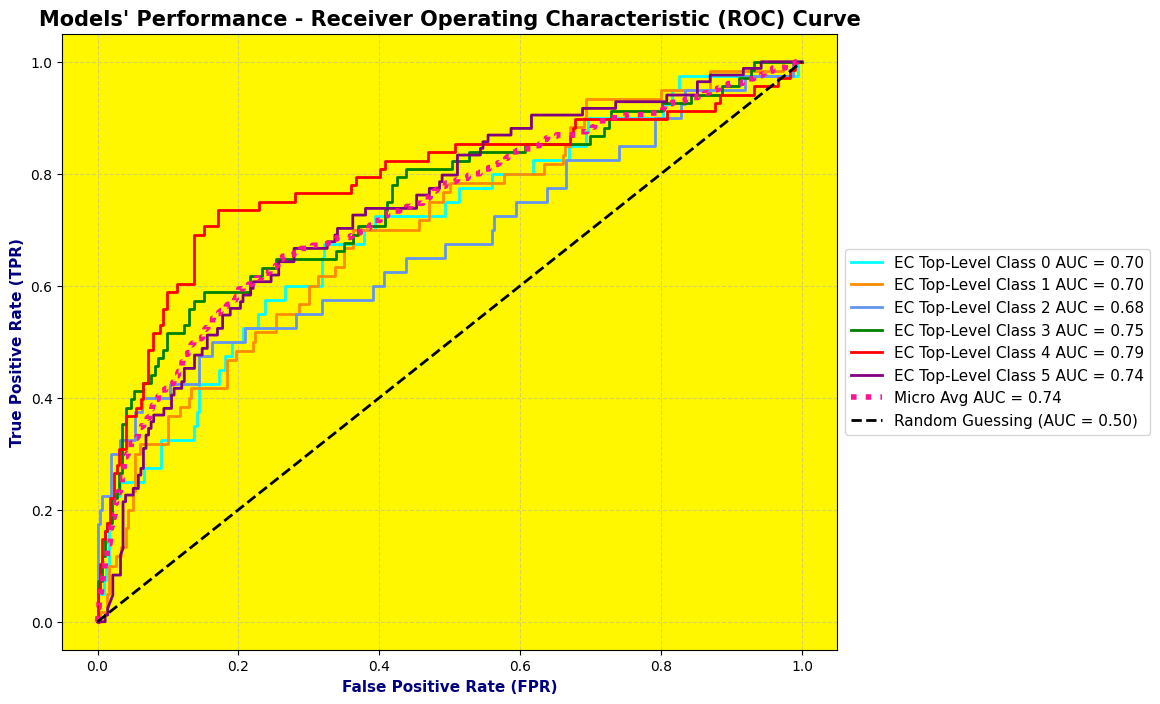

In [23]:
# Importing the necessary Python modules and libraries again, for the last time.
import os
import torch
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
from datetime import datetime

# Again, the directory where results are stored, as stated earlier
RESULTS_DIR = "model_results"

def plot_auc_curve():
    # Automatically fetch all ".pth" files in the directory mentioned above to access
    all_probs, all_labels = [], []
    num_classes = None

    for file_name in os.listdir(RESULTS_DIR):
        if file_name.endswith("_results.pth"):
            results = torch.load(os.path.join(RESULTS_DIR, file_name))
            all_probs.append(results["probs"])
            all_labels.append(results["labels"])
            num_classes = results["probs"].shape[1]  # Infer number of classes from probabilities
            print(" ")
            print(f"Loaded results for {results['model_name']}")
            print(" ")

    if not all_probs or not all_labels:
        print("No results found in the results directory. Run `test_model` first.")
        return

    # Combine results now
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)

    # One-hot Encoding for the labels
    # This will convert the categorical labels into a binary matrix/vector
    labels_onehot = np.zeros((all_labels.size, num_classes))
    labels_onehot[np.arange(all_labels.size), all_labels] = 1

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_onehot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_onehot.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"EC Top-Level Class {i} AUC = {roc_auc[i]:.2f}")

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label=f"Micro Avg AUC = {roc_auc['micro']:.2f}")
    # Diagonal Line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing (AUC = 0.50)")

    # Plot's Labels
    plt.xlabel("False Positive Rate (FPR)", fontsize=11, color="navy", fontweight="bold")
    plt.ylabel("True Positive Rate (TPR)", fontsize=11, color="navy", fontweight="bold")
    plt.title("Models' Performance - Receiver Operating Characteristic (ROC) Curve", fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid and Background
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.gca().set_facecolor("#FFF700")

    # Show the plot
    plt.show()

    # Print AUC Details
    print(f" ")
    print(f" ")
    print(f"                                    Micro Avg AUC: {roc_auc['micro']:.4f}")
    for i in range(num_classes):
        print(f"                                    EC Top-Level Class {i} AUC: {roc_auc[i]:.4f}")

    # Timestamp
    timestamp = datetime.now()
    print(f" ")
    print(f" ")
    print("                           Timestamp:", timestamp)

# Calling the Function to plot the AUC curve
plot_auc_curve()